In [ ]:
!pip install sentence-transformers

In [ ]:
import nltk
from nltk.corpus import wordnet
import pandas as pd
import random
import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt
import pickle
import string
from sklearn.model_selection import train_test_split #split data into train and test sets
from sklearn.feature_extraction.text import CountVectorizer #convert text comment into a numeric vector
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer #use TF IDF transformer to change text vector created by count vectorizer
from sklearn.svm import SVC, LinearSVC # Support Vector Machine
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import re
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_approximation import Nystroem
from sentence_transformers import SentenceTransformer
from time import time
from sklearn.svm import SVC
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Preprocessing Functions

In [ ]:
def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.append(l.name())
    return synonyms
stop = nltk.corpus.stopwords.words('english')

def augment_data(sent):
    words = sent.split()
    words = [w if w not in stop else '@'+w for w in words]
    for i in range(len(words)):
        if not words[i].startswith('@'):
            syn_w = get_synonyms(words[i])
            if syn_w != []:
                w = random.choice(syn_w)
                words[i] = " ".join(w.split('_'))
        else:
            words[i] = words[i][1:]
    return " ".join(words)

def preprocess_text(s):
    s = s.replace('\n',' ')
    s = s.replace('\t',' ')
    s = s.replace(':',' ')
    s = s.replace('#',' ')
    s = s.replace('*','u')
    s = s.replace('@','a')
    s = s.replace('$','s')
    s = s.replace('7','s')
    s = s.replace('2','to')
    s = s.replace('8','ight')
    s = s.replace('&', 'and')
    s = s.translate(str.maketrans('', '', string.punctuation) ) 
    s = s.split()
    s = [i for i in s if i]
    s = [re.sub("[^0-9a-zA-Z]+", "", i) for i in s]
    s = [i for i in s if len(i) > 1]
    
    return " ".join(s)


def transform_x(df):
    x = df.apply(lambda row : preprocess_text(row['comment_text']), axis=1)
    return pd.DataFrame(x,columns=['comment_text'])

def merge(df1,df2):
    return pd.concat([df1, df2], axis=1)


def drop_faulty_rows(df):
    return df.drop(df[(df['toxic'] == -1.0) & (df['severe_toxic'] == -1.0) & 
                    (df['obscene'] == -1.0) & (df['threat'] == -1.0) & 
                    (df['insult'] == -1.0) & (df['identity_hate'] == -1.0) ].index)
    
def combine_labels(train_df):
    x = np.where(train_df['toxic']+train_df['severe_toxic']+train_df['obscene']
             +train_df['threat']+train_df['insult']+train_df['identity_hate'] > 0, 1, 0)
    return pd.DataFrame(x,columns=['Toxic'])

# Training Data Transformation

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = pickle.load(open('/content/drive/MyDrive/Project/jigsaw-toxic-comment-classification-challenge/data/X_train-sentEmbed_chunk-1.pkl','rb'))
for i in range(2,21):
  X_train = np.append(X_train, pickle.load(open('/content/drive/MyDrive/Project/jigsaw-toxic-comment-classification-challenge/data/X_train-sentEmbed_chunk-'+str(i)+'.pkl','rb')),axis=0)
print(X_train.shape)

(159571, 768)


In [ ]:
y_train = pickle.load(open('/content/drive/MyDrive/Project/jigsaw-toxic-comment-classification-challenge/data/y_train_np.pkl','rb'))
print(y_train.shape)

(159571,)


## SVM using RBF kernel

In [ ]:
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train,y_train)

SVC()

In [ ]:
with open('/content/drive/MyDrive/Project/models/svm-embedding-rbf.pkl','wb') as handle:
    pickle.dump(svm_model, handle)

In [ ]:
X_test = pickle.load(open('/content/drive/MyDrive/Project/jigsaw-toxic-comment-classification-challenge/data/X_test-sentEmbed_chunk-1.pkl','rb'))
for i in range(2,9):
  X_test = np.append(X_test, pickle.load(open('/content/drive/MyDrive/Project/jigsaw-toxic-comment-classification-challenge/data/X_test-sentEmbed_chunk-'+str(i)+'.pkl','rb')),axis=0)
print(X_test.shape)

(63978, 768)


In [ ]:
y_test = pickle.load(open('/content/drive/MyDrive/Project/jigsaw-toxic-comment-classification-challenge/data/y_test_np.pkl','rb'))
print(y_test.shape)

(63978,)


In [ ]:
model = pickle.load(open('/content/drive/MyDrive/Project/models/svm-embedding-rbf.pkl','rb'))
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     57735
           1       0.63      0.69      0.66      6243

    accuracy                           0.93     63978
   macro avg       0.80      0.82      0.81     63978
weighted avg       0.93      0.93      0.93     63978



## SVM using sigmoid kernel

In [ ]:
svm_model_sigmoid = SVC(kernel='sigmoid')
svm_model_sigmoid.fit(X_train,y_train)
with open('/content/drive/MyDrive/Project/models/svm-embedding-sigmoid.pkl','wb') as handle:
    pickle.dump(svm_model_sigmoid, handle)

In [ ]:
model = pickle.load(open('/content/drive/MyDrive/Project/models/svm-embedding-sigmoid.pkl','rb'))
prediction = model.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     57735
           1       0.34      0.44      0.39      6243

    accuracy                           0.86     63978
   macro avg       0.64      0.68      0.65     63978
weighted avg       0.88      0.86      0.87     63978



## SVM using polynomial kernel

In [ ]:
svm_model_sigmoid = SVC(kernel='poly')
svm_model_sigmoid.fit(X_train,y_train)
with open('/content/drive/MyDrive/Project/models/svm-embedding-poly.pkl','wb') as handle:
    pickle.dump(svm_model_sigmoid, handle)

In [ ]:
svm_poly = pickle.load(open('/content/drive/MyDrive/Project/models/svm-embedding-poly.pkl','rb'))
prediction = svm_poly.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     57735
           1       0.63      0.70      0.66      6243

    accuracy                           0.93     63978
   macro avg       0.80      0.83      0.81     63978
weighted avg       0.93      0.93      0.93     63978



## Linear model using Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss='hinge', penalty='l2', epsilon=4, alpha=1e-6)
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=1e-06, epsilon=4)

In [ ]:
prediction = sgd_clf.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     57735
           1       0.59      0.65      0.62      6243

    accuracy                           0.92     63978
   macro avg       0.77      0.80      0.79     63978
weighted avg       0.92      0.92      0.92     63978



## Comparing results

### Kernel Approximation parameter tuning

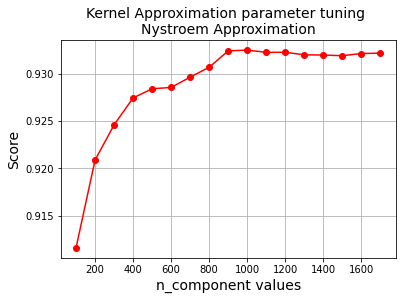

In [ ]:
nystroem_scores = [0.91159, 0.920879, 0.92461, 0.927459, 0.928428, 0.928569, 0.92966, 0.93071, 0.93244, 0.932523, 0.932289, 0.932289, 0.9320235, 0.932, 0.931929, 0.93216, 0.9322]
nystroem_values = np.arange(100,1800,100)
  
plt.plot(nystroem_values, nystroem_scores, color='red', marker='o')
plt.title('Kernel Approximation parameter tuning \nNystroem Approximation', fontsize=14)
plt.xlabel('n_component values', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.grid(True)
plt.show()

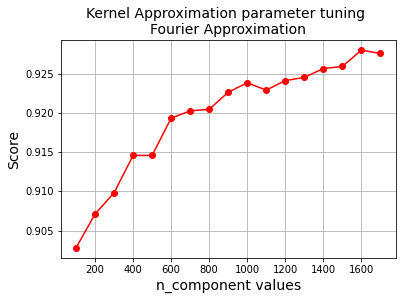

In [ ]:
fourier_scores = [0.9028, 0.9071, 0.90981, 0.91456438, 0.91458, 0.91933, 0.9202538, 0.920457, 0.92263, 0.923833, 0.9229, 0.9241145, 0.92452, 0.925646, 0.925912, 0.928, 0.92756885]
fourier_values = np.arange(100,1800,100)
  
plt.plot(fourier_values, fourier_scores, color='red', marker='o')
plt.title('Kernel Approximation parameter tuning \nFourier Approximation', fontsize=14)
plt.xlabel('n_component values', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.grid(True)
plt.show()

## Testing on custom sentences

In [ ]:
with open('/content/drive/MyDrive/Project/models/sbert_model.pkl','rb') as handle: 
    sbert_model = pickle.load(handle) 
def prediction(model, sent): 
    sent_vec = sbert_model.encode([preprocess_text(sent)]) 
    res = model.predict(sent_vec) 
    if res[0] == 1: 
        return 'Toxic' 
    return 'Non-Toxic'

In [ ]:
print(prediction(svm_poly, "Why don't these bastards leave us in peace"))

Toxic


In [ ]:
def augment_sentences(X,Y):
    maxlen = 15
    maxiter = 100
    augmented_sent = []
    for comment, label in zip(X,Y):
        varied_sent = set()
        itr = 0
        if label==1:
            while(len(varied_sent)<maxlen and itr < maxiter):
                varied_sent.add(augment_data(comment))
                itr += 1
        augmented_sent.extend([s for s in varied_sent])
        
    return augmented_sent

def sample_sent(sents, sample_size):
    return random.choices(sents, k=sample_size)

In [ ]:
feature_map_fourier = RBFSampler(gamma=0.2, random_state=1)
feature_map_nystroem = Nystroem(gamma=0.2, random_state=1)

fourier_approx_svm = Pipeline(
    [("feature_map", feature_map_fourier), ("svm", LinearSVC())]
)

nystroem_approx_svm = Pipeline(
    [("feature_map", feature_map_nystroem), ("svm", LinearSVC())]
)

linearSVM = Pipeline(
    [("svm", LinearSVC())]
)

In [ ]:
linearSVM.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('svm', LinearSVC())])

In [ ]:
prediction = linearSVM.predict(X_test)
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     57735
           1       0.59      0.72      0.65      6243

    accuracy                           0.92     63978
   macro avg       0.78      0.83      0.80     63978
weighted avg       0.93      0.92      0.93     63978



In [ ]:
sample_sizes = np.arange(100, 1100,100)
fourier_models = {}
nystroem_models = {}

for D in sample_sizes:

    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(X_train, y_train)
    nystroem_score = nystroem_approx_svm.score(X_test, y_test)

    print('Nystroem n_comp:{}\tTime:{}\tScore:{}'.format(D,round(time() - start,2), nystroem_score))
    start = time()
    fourier_approx_svm.fit(X_train, y_train)
    fourier_score = fourier_approx_svm.score(X_test, y_test)
    print('Fourier n_comp:{}\tTime:{}\tScore:{}'.format(D,round(time() - start,2), fourier_score))
    fourier_models['nystroem_n_comp{}'.format(D)] = nystroem_approx_svm
    nystroem_models['fourier_n_comp{}'.format(D)] = fourier_approx_svm


Nystroem n_comp:100	Time:12.4	Score:0.90241958173122
Fourier n_comp:100	Time:13.19	Score:0.90241958173122
Nystroem n_comp:200	Time:17.98	Score:0.90241958173122
Fourier n_comp:200	Time:18.73	Score:0.90241958173122
Nystroem n_comp:300	Time:26.07	Score:0.90241958173122
Fourier n_comp:300	Time:24.0	Score:0.90241958173122
Nystroem n_comp:400	Time:34.05	Score:0.90241958173122
Fourier n_comp:400	Time:31.12	Score:0.90241958173122
Nystroem n_comp:500	Time:44.67	Score:0.90241958173122
Fourier n_comp:500	Time:36.55	Score:0.90241958173122
Nystroem n_comp:600	Time:56.51	Score:0.90241958173122
Fourier n_comp:600	Time:42.86	Score:0.90241958173122
Nystroem n_comp:700	Time:72.38	Score:0.90241958173122
Fourier n_comp:700	Time:44.07	Score:0.90241958173122
Nystroem n_comp:800	Time:77.07	Score:0.90241958173122
Fourier n_comp:800	Time:49.77	Score:0.90241958173122
Nystroem n_comp:900	Time:89.55	Score:0.90241958173122
Fourier n_comp:900	Time:54.64	Score:0.90241958173122
Nystroem n_comp:1000	Time:103.05	Score:

In [ ]:
print("Metrics using Fourier approximation:")
prediction = fourier_approx_svm.predict(X_test)
print(classification_report(y_test, prediction))

Metrics using Fourier approximation:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     57735
           1       0.00      0.00      0.00      6243

    accuracy                           0.90     63978
   macro avg       0.45      0.50      0.47     63978
weighted avg       0.81      0.90      0.86     63978



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Metrics using Nystroem approximation:")
prediction = nystroem_approx_svm.predict(X_test)
print(classification_report(y_test, prediction))

Metrics using Nystroem approximation:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     57735
           1       0.00      0.00      0.00      6243

    accuracy                           0.90     63978
   macro avg       0.45      0.50      0.47     63978
weighted avg       0.81      0.90      0.86     63978



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
